# H2O Driverless AI on Azure

## Dataset and Use Case

### Dataset

For this demo, we will be using data from [Dallas OpenData](https://www.dallasopendata.com), namely, Dallas Animal Shelter Data FY [2015](https://www.dallasopendata.com/City-Services/FY-2015-Dallas-Animal-Shelter-Data/4j5h-8vay), [2016](https://www.dallasopendata.com/City-Services/FY-2016-Dallas-Animal-Shelter-Data/bg5d-mj5u), [2017](https://www.dallasopendata.com/City-Services/FY-2017-Dallas-Animal-Shelter-Data/sjyj-ydcj), and [2018](https://www.dallasopendata.com/City-Services/FY-2018-Dallas-Animal-Shelter-Data/7h2m-3um5).

Dallas Animal Shelter Data pertains to operational processes carried out by shelter personnel who assist citizens by receiving surrendered and stray animals, facilitating adoptions, transferring animals to rescue groups, and providing care to the animals in the shelter every day. The Dallas Animal Shelter Data is updated daily and includes records of every animal admitted and then dischared from the city shelters qualified by various intake and outcome attributes.

### Animal Survival Use Case
Amongst many possible scenarios Dallas Animal Shelter data may pertain one is of obvious interest: how and why animals survive or don't survive after being admitted to a shelter. For this purpose the data attributes collected at admission become independent variables and data attributes collected at discharge used to obtain outcome.

Available intake attributes:

  * animal type
  * breed
  * origin
  * census tract (neighborhood, see [Finding Census Tract Data: About Census Tracts](https://libguides.lib.msu.edu/tracts))
  * council district
  * intake type
  * intake subtype
  * reason
  * staff id
  * intake date
  * intake time
  * intake condition
  * chip status
  * animal origin
  * month
  * year
  
Available outcome attributes:

  * outcome type
  * outcome subtype
  * outcome condition
  
Dallas OpenData recently added [Animal Medical Record](https://www.dallasopendata.com/City-Services/FY-2018-Dallas-Animal-Medical-Record/utjn-mhn6) datasets for 2017 and 2018 but after collobarating them shelter records we determined insufficient amount of data. In a future when medical records become more pervasive they will be valuable addition to Dallas Animal Shelter models.

## Import Data

We imported and formatted datasets with [RSocrata](https://dev.socrata.com/libraries/) and [data.table](https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html) packages in R. Resulting data files formed training and test sets:

  * FY 2015-2017 training set: *dallas_animal_services_train.csv*
  * FY 2018 test set: *dallas_animal_services_test.csv*
  
Completed files were moved to Azure available to Driverless AI.

```r
library(data.table)
library(RSocrata)

#### some OSX work-around 
if (Sys.info()["sysname"] == "Darwin")
  Sys.setenv (TZ="America/Chicago")

#### Read Dallas Animal Shelters Data 2015 - 2018
data15.source = read.socrata(url = "https://www.dallasopendata.com/resource/8pn8-24ku.csv")
data16.source = read.socrata(url = "https://www.dallasopendata.com/resource/4qfv-27du.csv")
data17.source = read.socrata(url = "https://www.dallasopendata.com/resource/8849-mzxh.csv")
data18.source = read.socrata(url = "https://www.dallasopendata.com/resource/4jgt-nenk.csv")

#### Read Dallas Animal Medical Records 2018 (not used)
data18.recs.source = read.socrata(url = "https://www.dallasopendata.com/resource/5dkq-vasv.csv")
data17.recs.source = read.socrata(url = "https://www.dallasopendata.com/resource/tab8-7f9r.csv")

#### Create data tables for speed
dt15 = data.table(data15.source)
dt16 = data.table(data16.source)
dt17 = data.table(data17.source)
dt18 = data.table(data18.source)

#### Minimal changes to make all years compatible
dt15n16 = bind_rows(list(dt15,dt16))
dt15n16[, c("intake_time","outcome_time") := 
          list(strftime(intake_time, format="%H:%M:%S."), 
               strftime(outcome_time, format="%H:%M:%S."))]

names(dt17)[21] = 'month'

alldata = bind_rows(dt15n16,dt17,dt18)

alldogs = alldata[!is.na(outcome_date) & 
                    (intake_total == 1 | is.na(intake_total)) &
                    animal_type == 'DOG' &
                    !outcome_type %in% c("DEAD ON ARRIVAL","FOUND REPORT","LOST REPORT")]

alldogs[, c("activity_number","activity_sequence","tag_type",
            "animal_type","additional_information") := NULL]
alldogs[, c("intake_time", "outcome_time","month","lost",
            "intake_is_contagious","intake_treatable") := list(
  substring(intake_time, 1, 8),
  substring(outcome_time, 1, 8),
  substring(month, 1, 3),
  ifelse(outcome_type %in% c("DIED","EUTHANIZED","MISSING"), 1, 0),
  ifelse(is.na(str_match(intake_condition, ' CONTAGIOUS$')[,1]), 'NO','YES'),
  ifelse(is.na(str_match(intake_condition, '^TREATABLE ')[,1]), 'UNTREATABLE',
         ifelse(is.na(str_match(intake_condition, 'MANAGEABLE')[,1]),
                'REHABILITABLE', 'MANAGEABLE'))
)]
            
#### Write CSV Files       
fwrite(alldogs[!year %in% "FY2018"], file = "~/Projects/Playground/data/dallas_animal_services_train.csv")
fwrite(alldogs[year %in% "FY2018"], file = "~/Projects/Playground/data/dallas_animal_services_test.csv")
```

In [25]:
import pandas as pd
import numpy as np
import h2oai_client
# import h2o
import requests
import math
from h2oai_client import Client, ModelParameters, InterpretParameters

In [18]:
ip = "52.170.113.117"
server_address = 'http://' + ip + ':12345'
h2oai = Client(address = server_address, username = "h2oai", password = "h2oai")

In [37]:
print(list(map(lambda x: (x.key,x.name), h2oai.list_datasets(offset=0, limit=100))))

[('buhunavo', 'dallas_animal_services_weather_train.csv'), ('gacupapu', 'dallas_animal_services_weather_test.csv'), ('nalewohi', 'dallas_animal_services_train.csv'), ('necumove', 'dallas_animal_services_test.csv')]


In [15]:
# Datasets
dataset_key=h2oai.list_datasets(offset=0, limit=100)[2].key 
validset_key = '', # No validation data provided
testset_key=h2oai.list_datasets(offset=0, limit=100)[3].key
dataset_key,testset_key

('nalewohi', 'necumove')

In [8]:
print(list(map(lambda x: x.key, h2oai.list_models(offset=0, limit=100))))

['nuvuromu', 'nedurupe']


Run experiments with fixed accuracy (=3) and time (=3) and varying interpretability (from 2 to 10) to see how change in interpretability affects model performance.

In [19]:
experiment_array = np.empty((5))
for i in range(experiment_array.shape[0]):
    experiment = h2oai.start_experiment_sync(ModelParameters(
            
                dataset_key=dataset_key,
                validset_key='',
                testset_key=testset_key,
                
                # Columns
                target_col='lost',
                cols_to_drop=['animal_id','due_out','hold_request','impound_number',
                              'intake_total','kennel_status','kennel_number',
                              'outcome_condition','outcome_date','outcome_time','outcome_type',
                              'reason','receipt_number','service_request_number','source_id',
                              'staff_id','year','outcome_subtype'],
                weight_col='',
                fold_col='',
                time_col='intake_date',
                
                # Parameters
                is_classification=True,
                enable_gpus=True,
                seed=1234,
                
                accuracy=3,
                time=3,
                interpretability=(i + 1) * 2, 
    
                scorer="AUC"
            ))
    experiment_array[i] = experiment.test_score

In [20]:
float_formatter = lambda x: "%.5f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

print(experiment_array)

[0.82437 0.82517 0.82402 0.81725 0.82075]


In [31]:
xs = (np.arange(0,experiment_array.shape[0]) + 1) * 2
ys = experiment_array

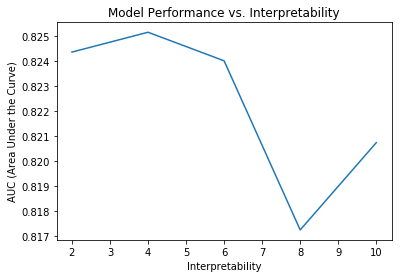

In [36]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.plot(xs, ys)
plt.title('Model Performance vs. Interpretability')
plt.xlabel('Interpretability')
plt.ylabel('AUC (Area Under the Curve)')
plt.show()